In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Storm_Figs_V6.2.3/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_All_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_All_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Birth_Time, Start_Time, End_Time, Death_Time, Peak_Time = [], [], [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Birth_Time.append(Datetime(ET_DF["Genesis Time"][j]))
        Start_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        End_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Death_Time.append(Datetime(ET_DF["Dissipate Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["Genesis Time"] = Birth_Time
    ET_DF["ET Begin Time"] = Start_Time
    ET_DF["ET Complete Time"] = End_Time
    ET_DF["Dissipate Time"] = Death_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [7]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [8]:
# Define Cyclone Type, Set Shape and Colour Code
SLP_Colours = ['darkviolet', 'mediumvioletred', 'magenta', 'red', 'orangered', \
'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'limegreen', 'deepskyblue', 'cyan']
SLP_Bounds = Create_Bins(900,1010,10)
def Cyclone_Type(DF, ET_DF, Storm_List):
# Cyclone Type and Shape Code
    Cyclone_Type = []
    Plot_Shape = []
    for i in range(len(DF["Storm Phase"])):
        if DF["Storm Phase"][i] == "Tropical":
            Plot_Shape.append('o')
        elif DF["Storm Phase"][i] == "Transition":
            Plot_Shape.append('s')
        elif DF["Storm Phase"][i] == "Extratropical":
            Plot_Shape.append('^')
        else:
            print (DF["Storm Type"][i])
    DF["Plot Shape"] = Plot_Shape
#    
# SLP Colour Code
    Plot_Colour = []
    for i in range(len(DF["SLP(hPa)"])):
        for k in range(len(SLP_Colours)):
            if k == 0:
                if DF["SLP(hPa)"][i] <= SLP_Bounds[k]:
                    Plot_Colour.append(SLP_Colours[k])
            elif k != len(SLP_Colours)-1:
                if DF["SLP(hPa)"][i] <= SLP_Bounds[k] and DF["SLP(hPa)"][i] > SLP_Bounds[k-1]:
                    Plot_Colour.append(SLP_Colours[k])
            else:
                if DF["SLP(hPa)"][i] > SLP_Bounds[k-1]:
                    Plot_Colour.append(SLP_Colours[k])
    DF["Plot Colour"] = Plot_Colour
    return (DF)

In [9]:
Control_Data_Plot = Cyclone_Type(Control_Data, Control_ET, Control_Codes["New Code"])
RCP45_Data_Plot = Cyclone_Type(RCP45_Data, RCP45_ET, RCP45_Codes["New Code"])
RCP85_Data_Plot = Cyclone_Type(RCP85_Data, RCP85_ET, RCP85_Codes["New Code"])

In [10]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    DF_Storm = DF_Storm.drop("index", axis=1)
    return (DF_Storm)

In [11]:
# Create Legend
def Plot_TC_Legend(Loc):
    pyplot.scatter([-728], [-728], c='cyan', marker='o', linewidths=0.8, edgecolors='black', label='Tropical')
    pyplot.scatter([-728], [-728], c='cyan', marker='s', linewidths=0.8, edgecolors='black', label='Transition')
    pyplot.scatter([-728], [-728], c='cyan', marker='^', linewidths=0.8, edgecolors='black', label='Extratropical')
    pyplot.legend(loc=Loc, fontsize=12)

In [49]:
# Plot Cyclone Phase Diagram
def Plot_Cyclone_Info(Storm_Name, DF_Storm, ET_Storm, Bounds, Colours, Loc, Trans, Model, Fig_Label, Savefig):
    VLT = numpy.array(DF_Storm['VLT'])[1:]
    VUT = numpy.array(DF_Storm['VUT'])[1:]
    B = numpy.array(DF_Storm['B'])[1:]
    Time = list(DF_Storm['Time(Z)'])
    SLP = numpy.array(DF_Storm['SLP(hPa)'])
    Lon = numpy.array(DF_Storm['Lon'])
    Lat = numpy.array(DF_Storm['Lat'])
    Plot_Colour = list(DF_Storm['Plot Colour'])
    Plot_Shape = list(DF_Storm['Plot Shape'])
    Plot_Colour_1 = list(DF_Storm['Plot Colour'])[1:]
    Plot_Shape_1 = list(DF_Storm['Plot Shape'])[1:]
#
# Plotting VUT VLT
    Fig = pyplot.figure(figsize=(16,16))
    Axis = Fig.add_subplot(2,2,1)
    x_Axis = Create_Bins(-500,500,100)
    y_Axis = Create_Bins(-30,120,10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-30,120)
    pyplot.fill_between([0,500], 15, 120, color='violet', alpha=0.2)
    pyplot.fill_between([-500,0], 15, 120, color='mediumblue', alpha=0.2)
    pyplot.fill_between([0,500], -30, 15, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], -30, 15, color='darkgrey', alpha=0.2)
    pyplot.plot([-500,500], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-30,120], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    Axis.plot(VLT, B, c='black', linewidth=0.5, alpha=0.5)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], B[k], c=Plot_Colour_1[k], marker=Plot_Shape_1[k], linewidths=0.5, edgecolors='black', s=78)
    if Trans == True:
        Trans_Type = ET_Storm["Trans Type"][0]
        if Trans_Type > -1:
            Start_Time = ET_Storm["ET Begin Time"][0]
            Start_DF = DF_Storm[DF_Storm["Time(Z)"] == Start_Time]
            pyplot.scatter(Start_DF["VLT"], Start_DF["B"], marker='s', linewidths=4.8, \
            facecolors='none', edgecolors='black', s=178)
            if Trans_Type > 0:
                End_Time = ET_Storm["ET Complete Time"][0]
                End_DF = DF_Storm[DF_Storm["Time(Z)"] == End_Time]
                pyplot.scatter(End_DF["VLT"], End_DF["B"]+0.5, marker='^', linewidths=4.2, \
                facecolors='none', edgecolors='black', s=208)
    Title = str(Model + ': ' + DF_Storm['Code'][0] + ' ' + DF_Storm['Name'][0])
    Axis.set_title(Title, fontsize=18)
    Plot_TC_Legend(Loc)
    if Fig_Label == True:
        Letter_Label(Axis, Storm_Name, 0)
#
# Plotting VUT VLT
    Axis = Fig.add_subplot(2,2,2)
    x_Axis = Create_Bins(-500,500,100)
    y_Axis = Create_Bins(-500,500,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-500,500)
    pyplot.fill_between([0,500], 500, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], 500, color='lightskyblue', alpha=0.2)
    pyplot.fill_between([0,500], -500, color='orangered', alpha=0.2)
    pyplot.fill_between([-500,0], -500, color='mediumblue', alpha=0.2)
    pyplot.plot([-500,500], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-500,500], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    Axis.plot(VLT, VUT, c='black', linewidth=0.5, alpha=0.5)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], VUT[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.5, edgecolors='black', s=78)
    if Trans == True:
        Trans_Type = ET_Storm["Trans Type"][0]
        if Trans_Type > -1:
            Start_Time = ET_Storm["ET Begin Time"][0]
            Start_DF = DF_Storm[DF_Storm["Time(Z)"] == Start_Time]
            pyplot.scatter(Start_DF["VLT"], Start_DF["VUT"], marker='s', linewidths=4.8, \
            facecolors='none', edgecolors='black', s=178)
            if Trans_Type > 0:
                End_Time = ET_Storm["ET Complete Time"][0]
                End_DF = DF_Storm[DF_Storm["Time(Z)"] == End_Time]
                pyplot.scatter(End_DF["VLT"], End_DF["VUT"]+0.5, marker='^', linewidths=4.2, \
                facecolors='none', edgecolors='black', s=208)
    Axis.set_title(Title, fontsize=18)
    if Fig_Label == True:
        Letter_Label(Axis, Storm_Name, 1)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.6, -0.095, 1, 0.025], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', spacing='proportional', \
    cax=Cax, label='SLP(hPa)', shrink=0.7)
#
# Plotting Storm Track
    Axis = Fig.add_subplot(2,2,3, projection=ccrs.PlateCarree())
    Axis.coastlines(linewidth=0.5)
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    Axis.plot(Lon, Lat, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Lon)):
        pyplot.scatter(Lon[k], Lat[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.5, edgecolors='black', s=78)
    if Trans == True:
        Trans_Type = ET_Storm["Trans Type"][0]
        if Trans_Type > -1:
            pyplot.scatter(ET_Storm["ET Begin Lon"][0], ET_Storm["ET Begin Lat"][0], marker='s', \
            linewidths=4.8, facecolors='none', edgecolors='black', s=178)
            if Trans_Type > 0:
                pyplot.scatter(ET_Storm["ET Complete Lon"][0], ET_Storm["ET Complete Lat"][0]+0.1, marker='^', \
                linewidths=4.2, facecolors='none', edgecolors='black', s=208)
    if Storm_Name == "Melody":
        x_Min = -80
        x_Max = -30
        y_Min = 10
        y_Max = 60
    if Storm_Name == "Cissy":
        x_Min = -85
        x_Max = -40
        y_Min = 10
        y_Max = 55
    if Storm_Name == "Maho":
        x_Min = -85
        x_Max = -35
        y_Min = 5
        y_Max = 55
    if Storm_Name == "Kinen":
        x_Min = -85
        x_Max = -40
        y_Min = 10
        y_Max = 55
    if Storm_Name == "Grace":
        x_Min = -80
        x_Max = -30
        y_Min = 10
        y_Max = 60
    if Storm_Name == "Shannon":
        x_Min = -60
        x_Max = -15
        y_Min = 10
        y_Max = 55
    if Storm_Name == "Yan":
        x_Min = -45
        x_Max = 10
        y_Min = 10
        y_Max = 65
    if Storm_Name == "Rachel":
        x_Min = -85
        x_Max = -35
        y_Min = 10
        y_Max = 60
    if Storm_Name == "Sergio":
        x_Min = -90
        x_Max = -35
        y_Min = 0
        y_Max = 55
    x_Axis = Create_Bins(x_Min,x_Max,5)
    y_Axis = Create_Bins(y_Min,y_Max,5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
#    Title = str(Model + ': ' + DF_Storm['Code'][0] + ' ' + DF_Storm['Name'][0])
#    Axis.set_title(Title, fontsize=16)
    Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='silver', linestyle='-')
    Gridline.xlocator = mticker.FixedLocator(x_Axis)
    Gridline.ylocator = mticker.FixedLocator(y_Axis)
    if Fig_Label == True:
        Letter_Label(Axis, Storm_Name, 2)
#
# Plotting Storm SLP
    Axis = Fig.add_subplot(2,2,4)
    Axis.plot(Time, SLP, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Time)):
        Axis.scatter(Time[k], SLP[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.8, edgecolors='black', s=78)
    if Trans == True:
        Trans_Type = ET_Storm["Trans Type"][0]
        if Trans_Type > -1:
            pyplot.scatter(ET_Storm["ET Begin Time"][0], ET_Storm["ET Begin SLP"][0], marker='s', \
            linewidths=4.8, facecolors='none', edgecolors='black', s=178)
            if Trans_Type > 0:
                pyplot.scatter(ET_Storm["ET Complete Time"][0], ET_Storm["ET Complete SLP"][0]+0.2, marker='^', \
                linewidths=4.2, facecolors='none', edgecolors='black', s=208)
    pyplot.xlabel('Time (Z)', fontsize=12)
    pyplot.ylabel('Sea Level Pressure (SLP)', fontsize=12)
    x_Min = Time[0] + datetime.timedelta(hours=-6)
    x_Max = Time[len(Time)-1] + datetime.timedelta(hours=6)
    x_Start = datetime.date(x_Min.year,x_Min.month,x_Min.day) + datetime.timedelta(1)
    x_End = datetime.date(x_Max.year,x_Max.month,x_Max.day) + datetime.timedelta(1)
    if Storm_Name == "Melody":
        x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
        y_Min = 890
        y_Max = 1010
    if Storm_Name == "Cissy":
        x_Axis = pandas.date_range(x_Start,x_End,freq='2D')
        y_Min = 890
        y_Max = 1010
    if Storm_Name == "Maho":
        x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
        y_Min = 880
        y_Max = 1010
    if Storm_Name == "Kinen":
        x_Axis = pandas.date_range(x_Start,x_End,freq='2D')
        y_Min = 920
        y_Max = 1010
    if Storm_Name == "Grace":
        x_Axis = pandas.date_range(x_Start,x_End,freq='2D')
        y_Min = 940
        y_Max = 1020
    if Storm_Name == "Shannon":
        x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
        y_Min = 920
        y_Max = 1010
    if Storm_Name == "Yan":
        x_Axis = pandas.date_range(x_Start,x_End,freq='2D')
        y_Min = 940
        y_Max = 1010
    if Storm_Name == "Rachel":
        x_Axis = pandas.date_range(x_Start,x_End,freq='4D')
        y_Min = 900
        y_Max = 1010
    if Storm_Name == "Sergio":
        x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
        y_Min = 890
        y_Max = 1010
    y_Axis = Create_Bins(y_Min,y_Max,10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    if Fig_Label == True:
        Letter_Label(Axis, Storm_Name, 3)
#
# Save Fig
    if Savefig == True:
        Figname = str('Selected_' + DF_Storm['Code'][0] + '_' + DF_Storm['Name'][0] + '.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [13]:
def Letter_Label(Axis, Storm_Name, Plot):
    if Storm_Name == "Melody" or Storm_Name == "Cissy" or Storm_Name == "Maho":
        Fig_Labels = ['(a)','(b)','(c)','(d)']
    if Storm_Name == "Kinen" or Storm_Name == "Grace" or Storm_Name == "Shannon":
        Fig_Labels = ['(e)','(f)','(g)','(h)']
    if Storm_Name == "Yan" or Storm_Name == "Rachel" or Storm_Name == "Sergio":
        Fig_Labels = ['(i)','(j)','(k)','(l)']
    if Plot <= 1:
        Axis.text(0.08, 0.92, str(Fig_Labels[int(Plot)]), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':18},color='black')
    else:
        Axis.text(0.08, 0.08, str(Fig_Labels[int(Plot)]), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':18},color='black')

In [14]:
DF_Melody = Find_Storm(Control_Data, "TC191304")

In [15]:
ET_Melody = Find_Storm(Control_ET, "TC191304")

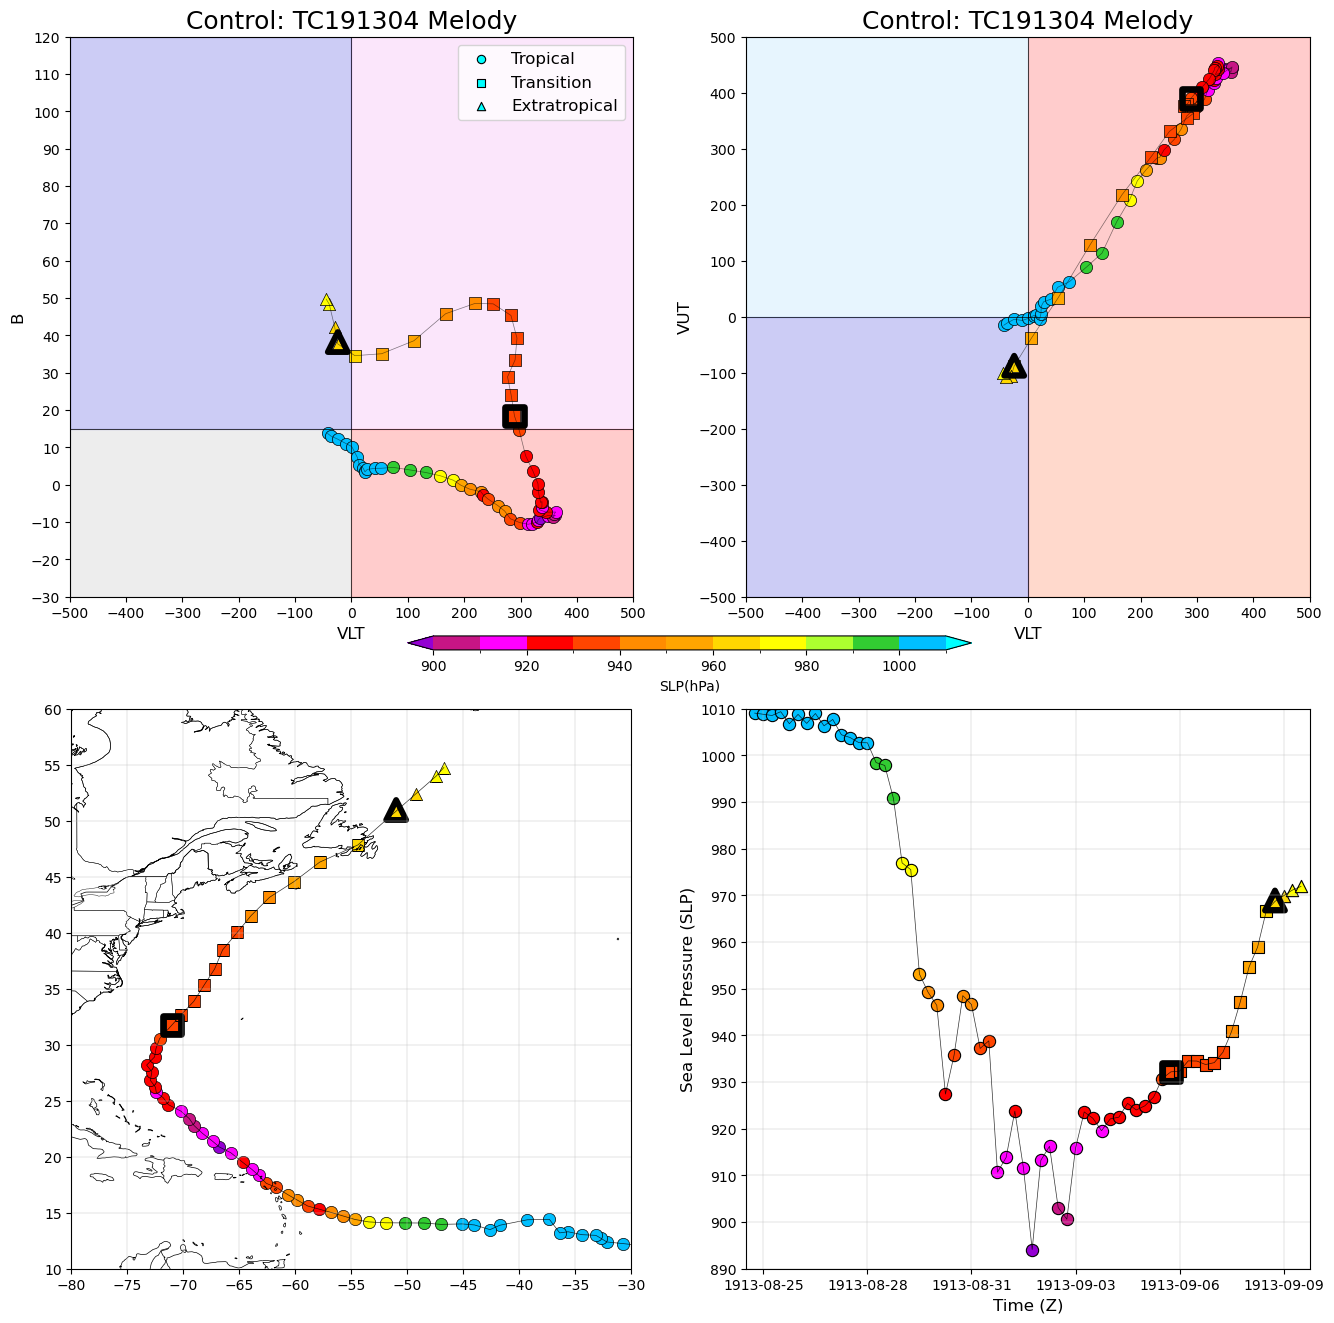

In [16]:
# Input Code
Plot_Cyclone_Info("Melody", DF_Melody, ET_Melody, SLP_Bounds, SLP_Colours, 1, True, "Control", False, True)

In [17]:
DF_Cissy = Find_Storm(Control_Data, "TC195008")

In [18]:
ET_Cissy = Find_Storm(Control_ET, "TC195008")

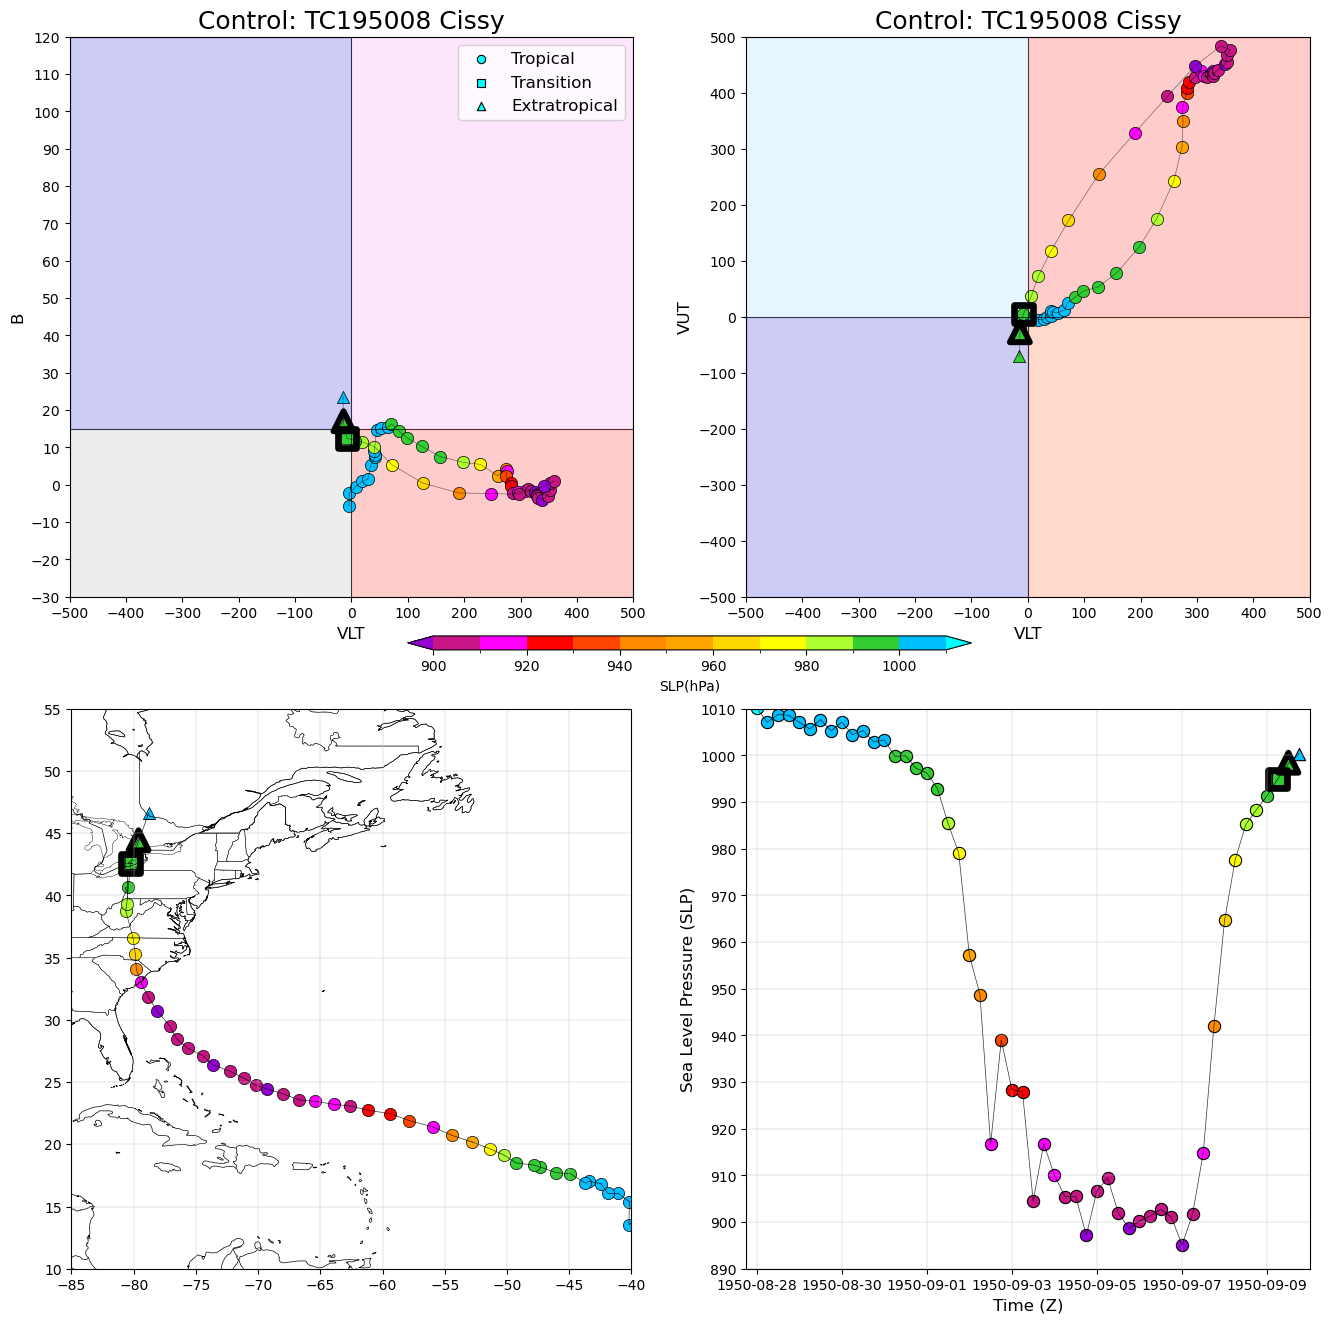

In [19]:
# Input Code
Plot_Cyclone_Info("Cissy", DF_Cissy, ET_Cissy, SLP_Bounds, SLP_Colours, 1, True, "Control", False, True)

In [20]:
DF_Maho = Find_Storm(Control_Data, "TC197807")

In [21]:
ET_Maho = Find_Storm(Control_ET, "TC197807")

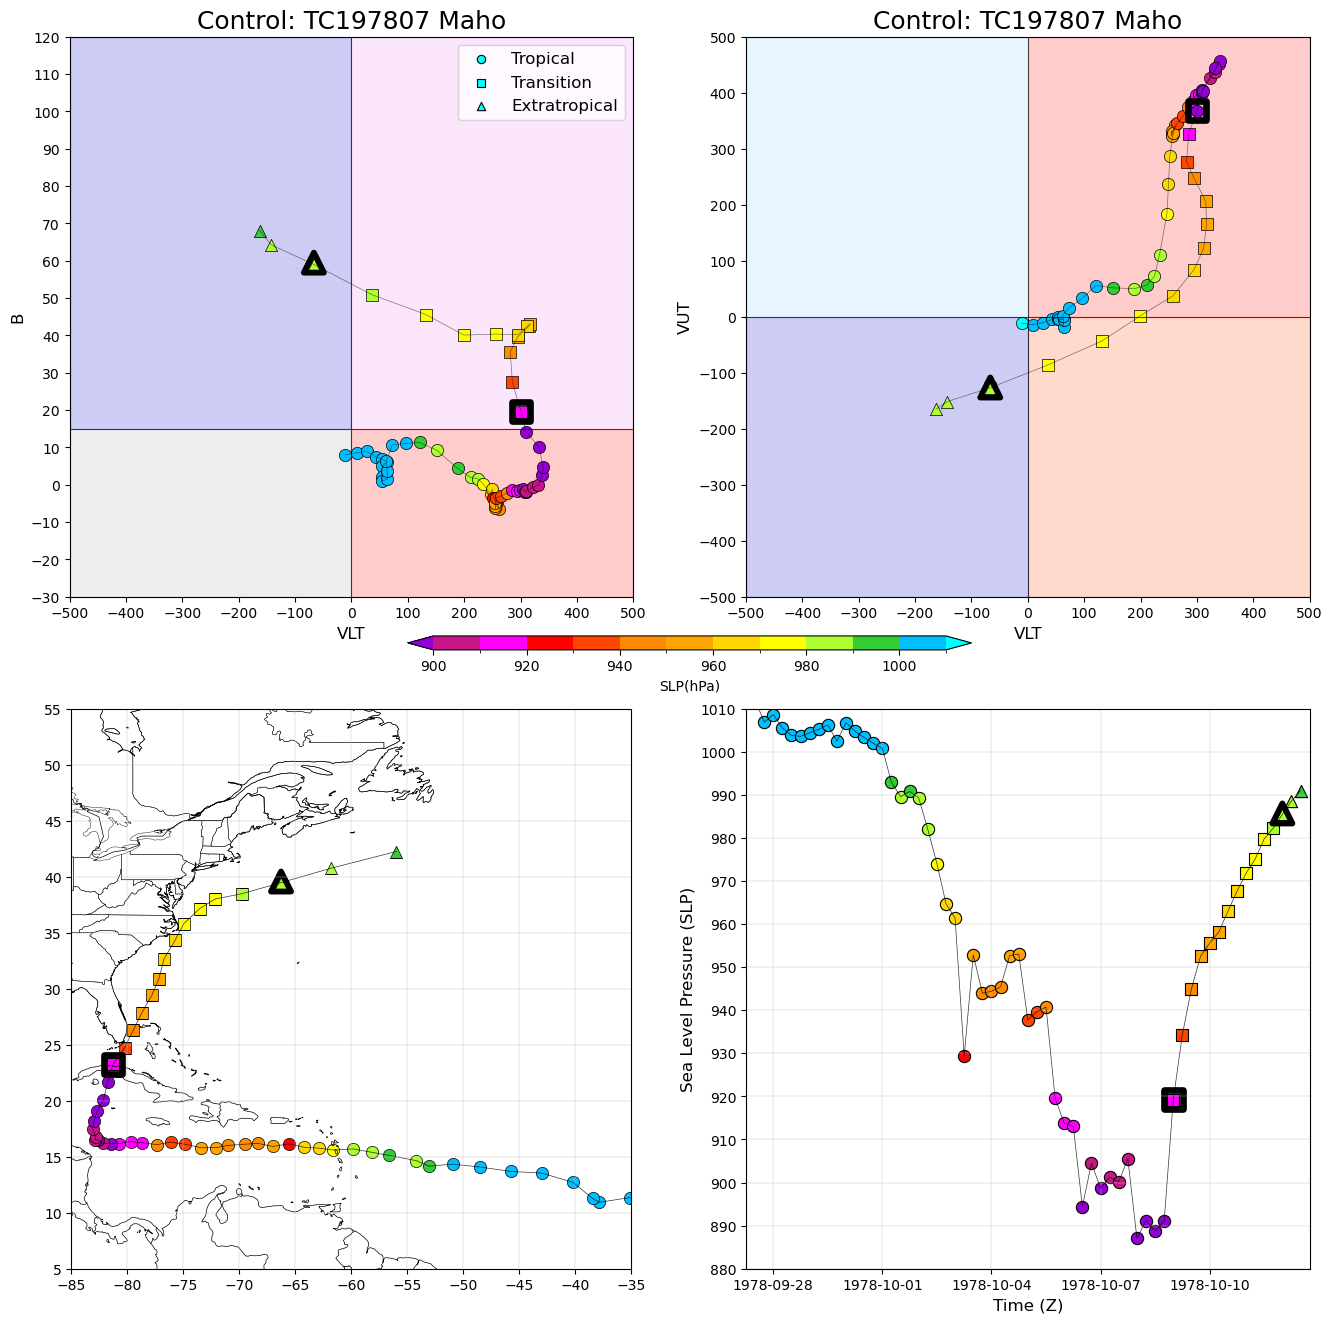

In [22]:
# Input Code
Plot_Cyclone_Info("Maho", DF_Maho, ET_Maho, SLP_Bounds, SLP_Colours, 1, True, "Control", False, True)

In [46]:
DF_Grace = Find_Storm(RCP45_Data, "TC202006")

In [47]:
ET_Grace = Find_Storm(RCP45_ET, "TC202006")

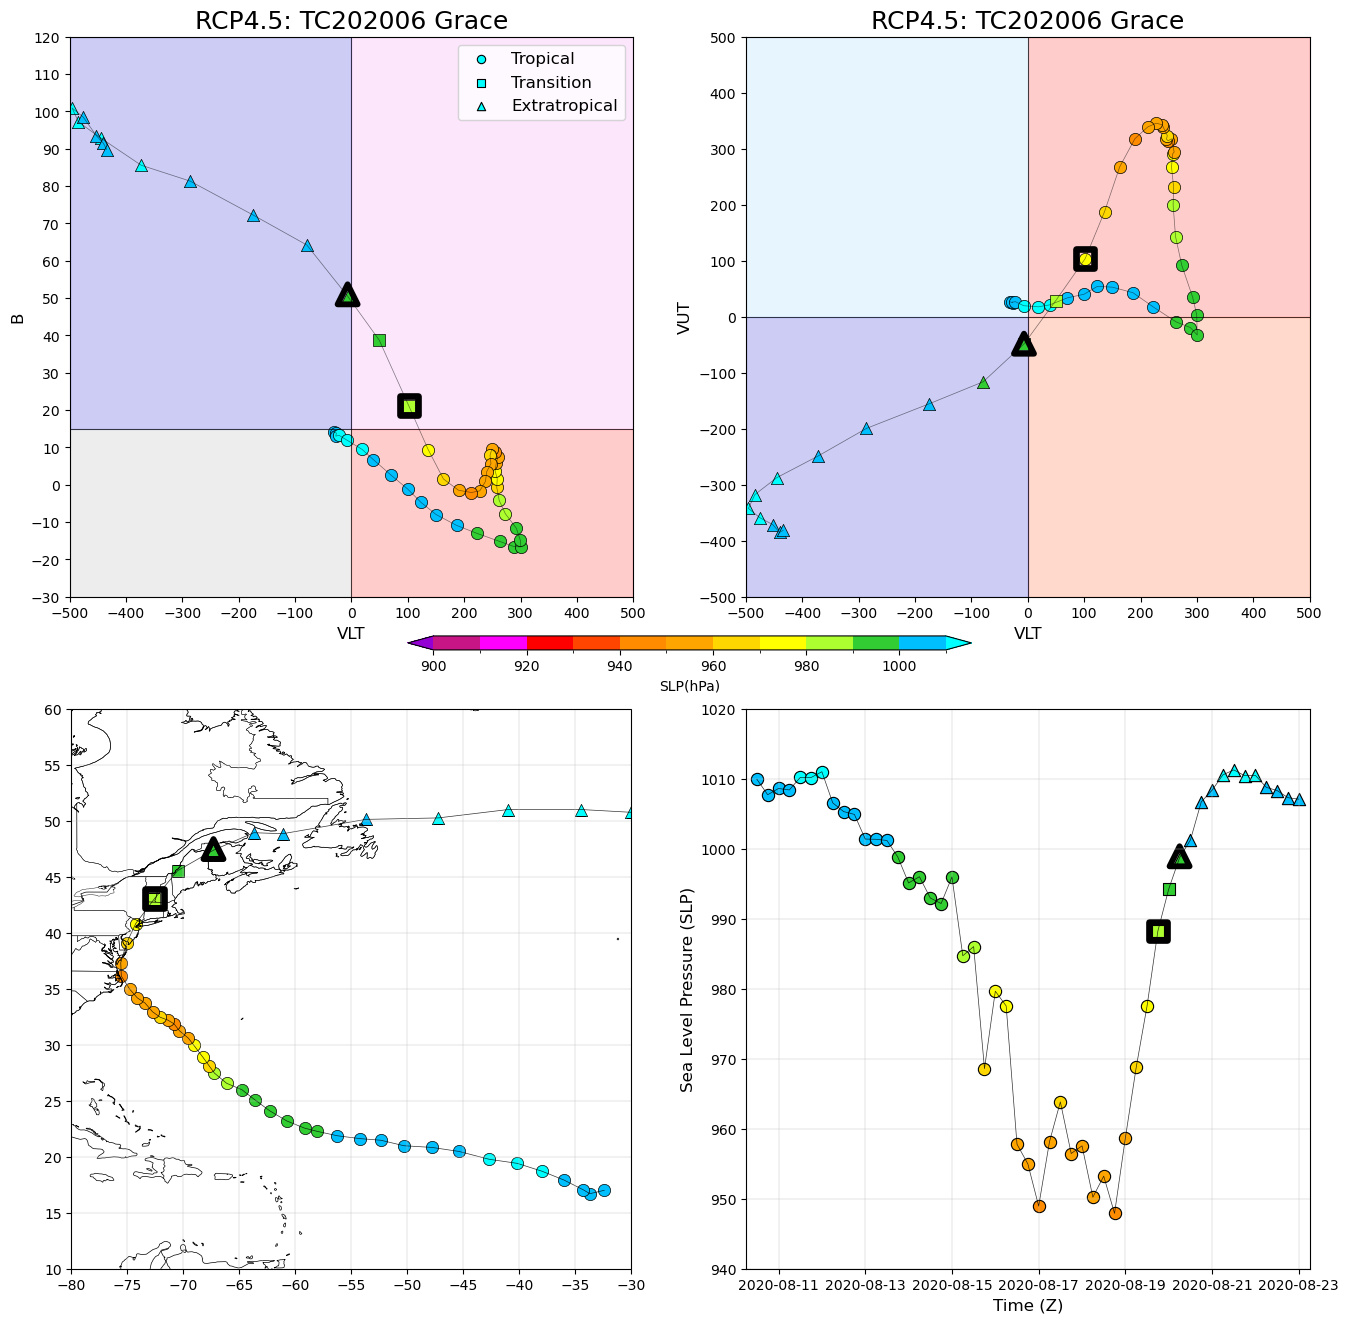

In [50]:
# Input Code
Plot_Cyclone_Info("Grace", DF_Grace, ET_Grace, SLP_Bounds, SLP_Colours, 1, True, "RCP4.5", False, True)

In [26]:
DF_Kinen = Find_Storm(RCP45_Data, "TC202009")

In [27]:
ET_Kinen = Find_Storm(RCP45_ET, "TC202009")

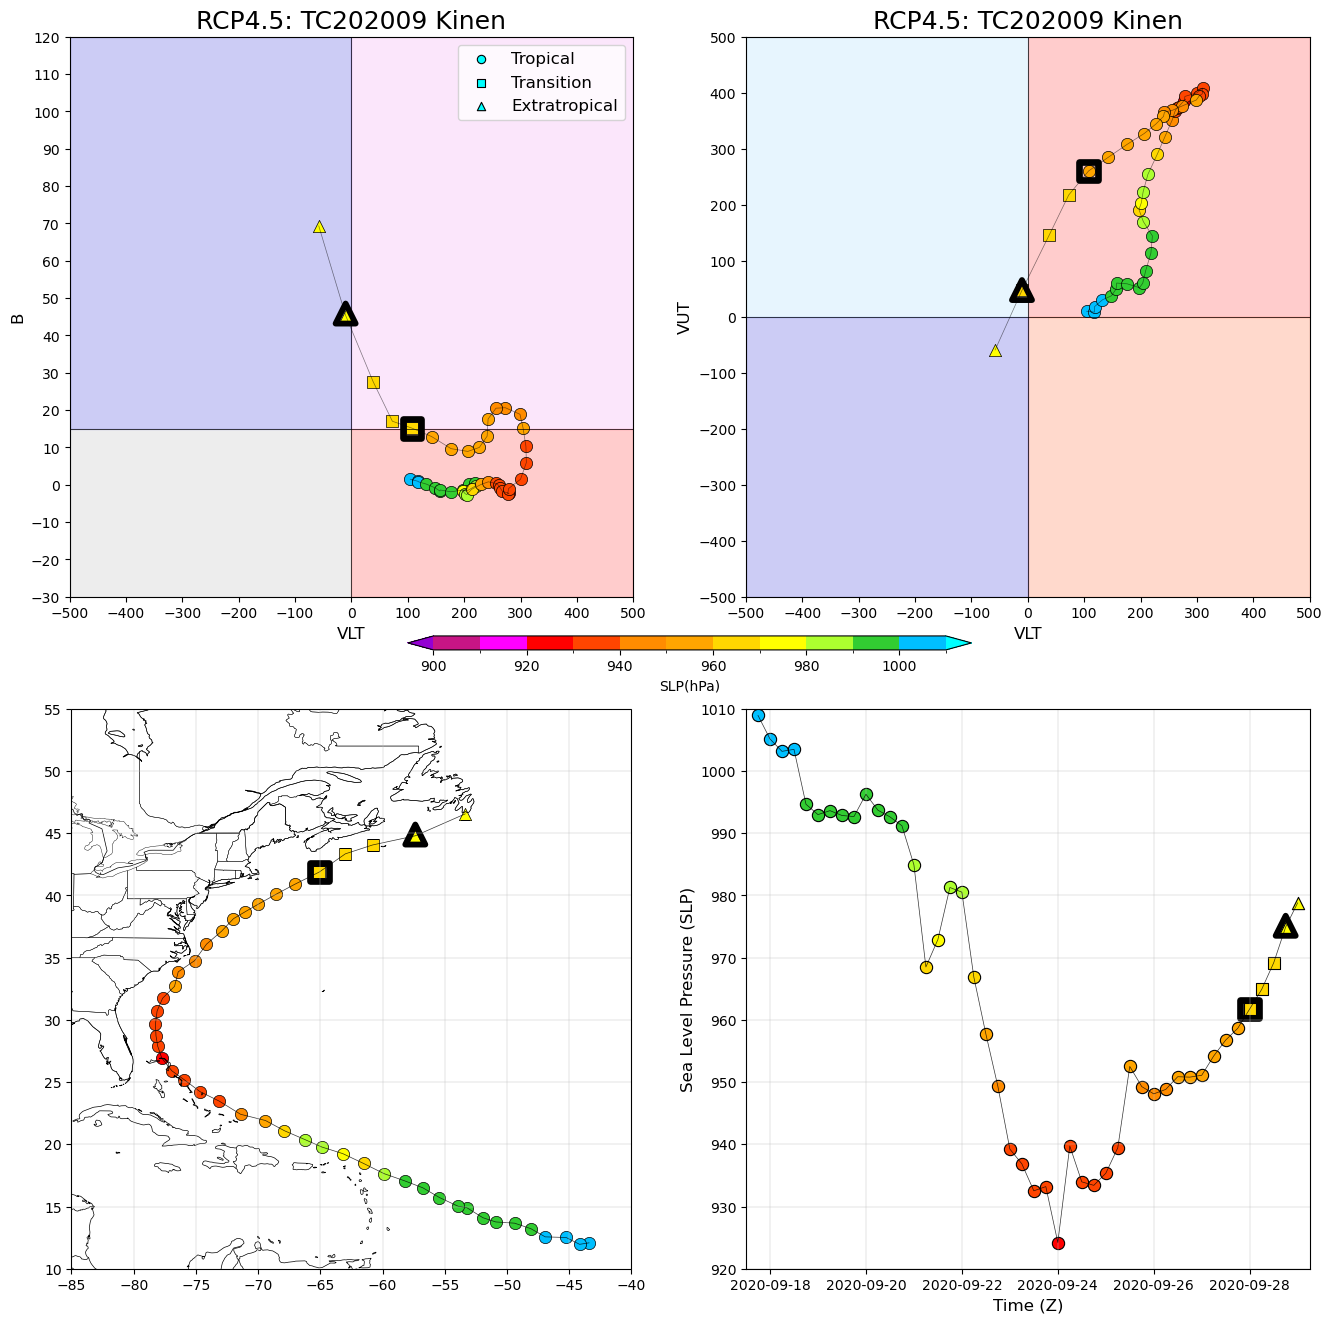

In [28]:
# Input Code
Plot_Cyclone_Info("Kinen", DF_Kinen, ET_Kinen, SLP_Bounds, SLP_Colours, 1, True, "RCP4.5", False, True)

In [29]:
DF_Shannon = Find_Storm(RCP45_Data, "TC208507")

In [30]:
ET_Shannon = Find_Storm(RCP45_ET, "TC208507")

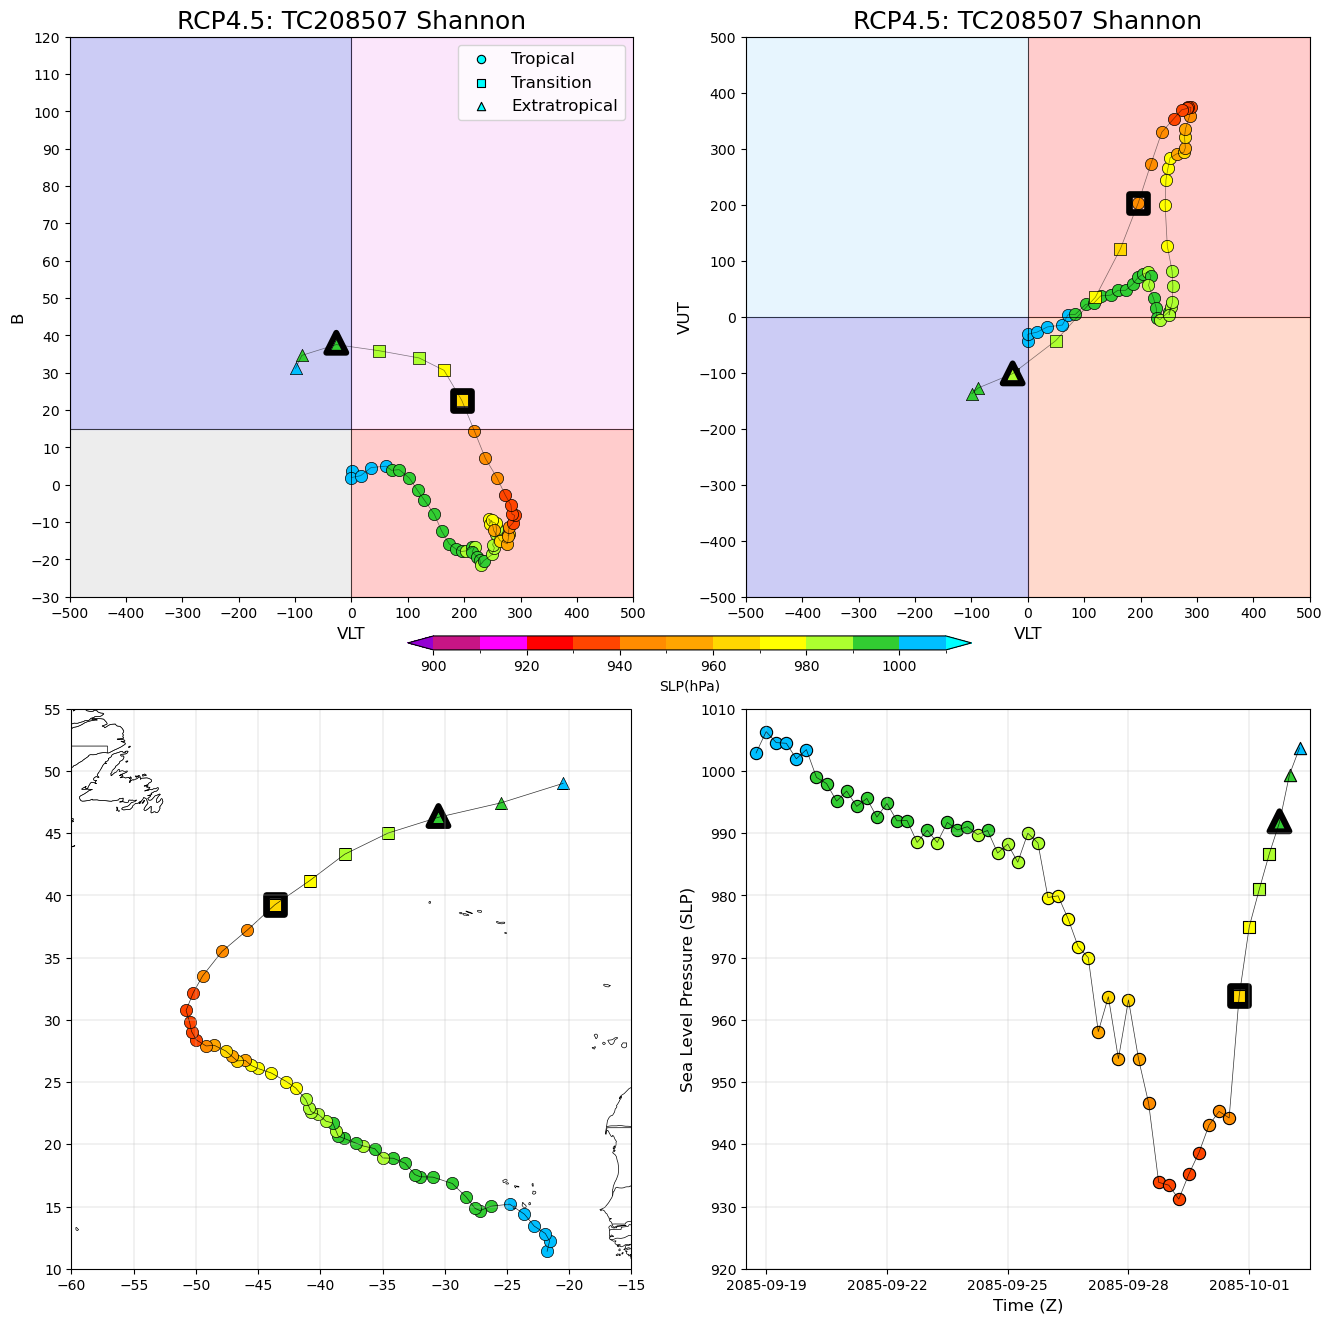

In [31]:
# Input Code
Plot_Cyclone_Info("Shannon", DF_Shannon, ET_Shannon, SLP_Bounds, SLP_Colours, 1, True, "RCP4.5", False, True)

In [32]:
DF_Yan = Find_Storm(RCP85_Data, "TC211606")

In [33]:
ET_Yan = Find_Storm(RCP85_ET, "TC211606")

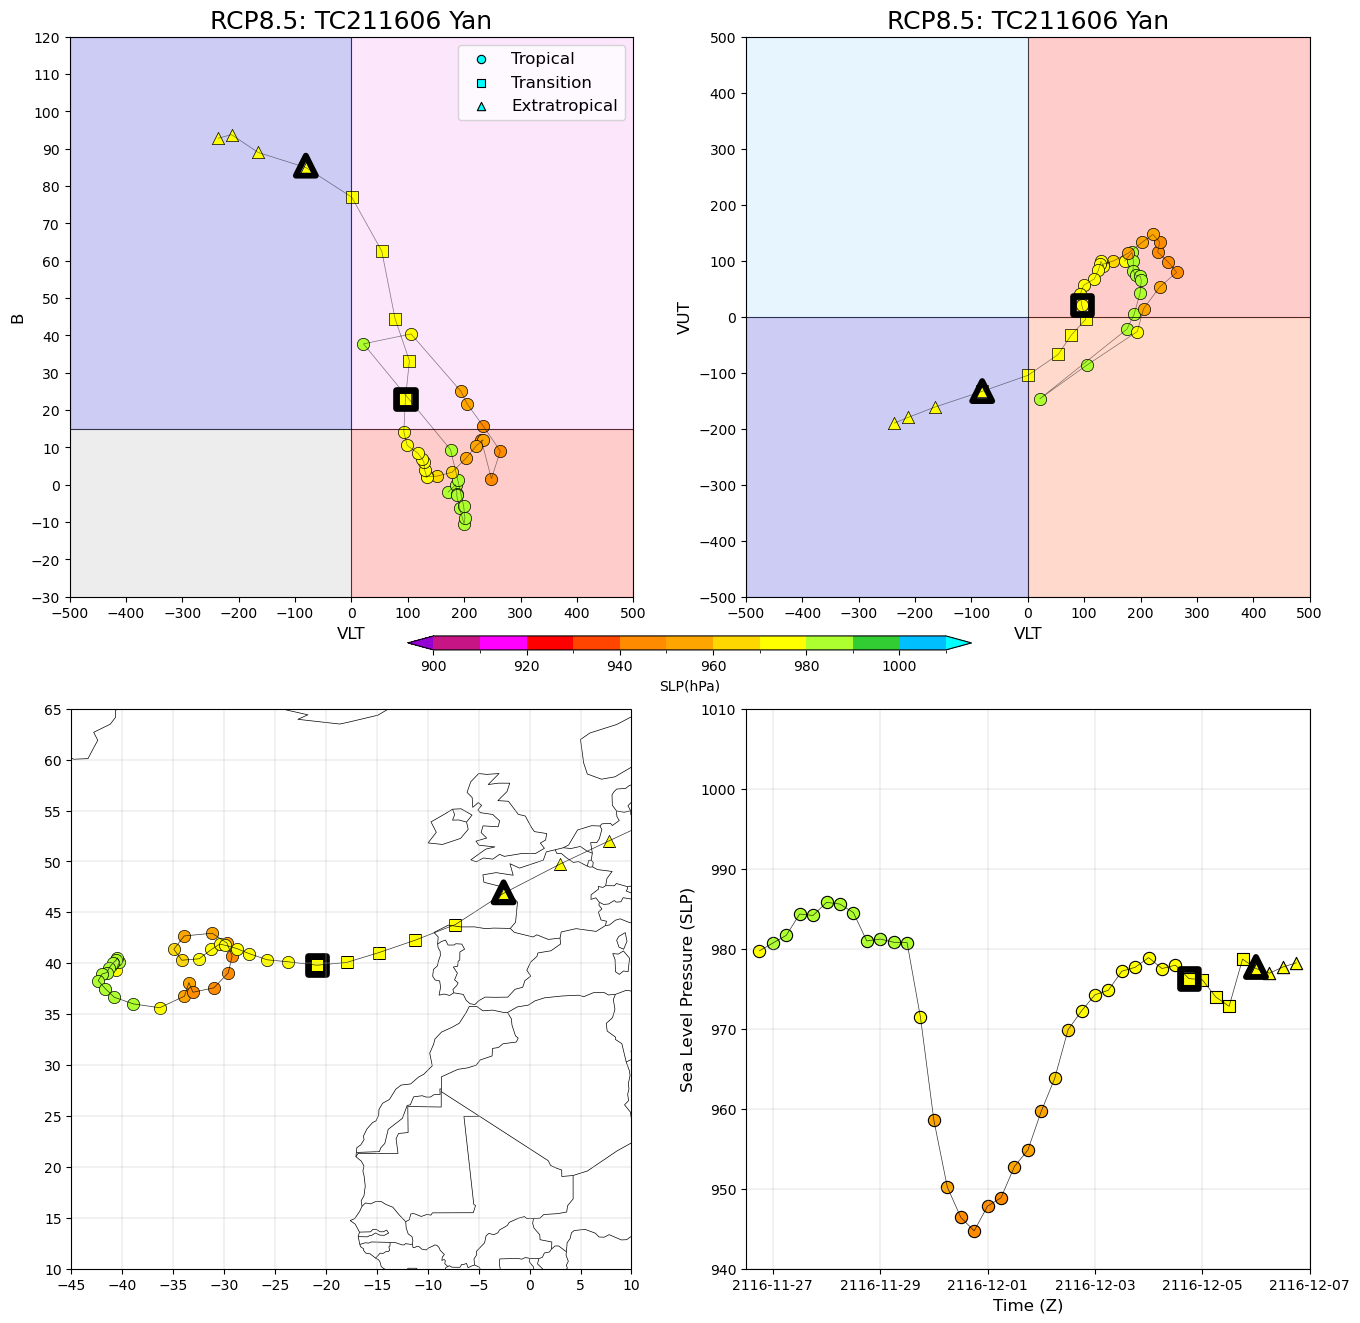

In [34]:
# Input Code
Plot_Cyclone_Info("Yan", DF_Yan, ET_Yan, SLP_Bounds, SLP_Colours, 1, True, "RCP8.5", False, True)

In [35]:
DF_Sergio = Find_Storm(RCP85_Data, "TC219007")

In [36]:
ET_Sergio = Find_Storm(RCP85_ET, "TC219007")

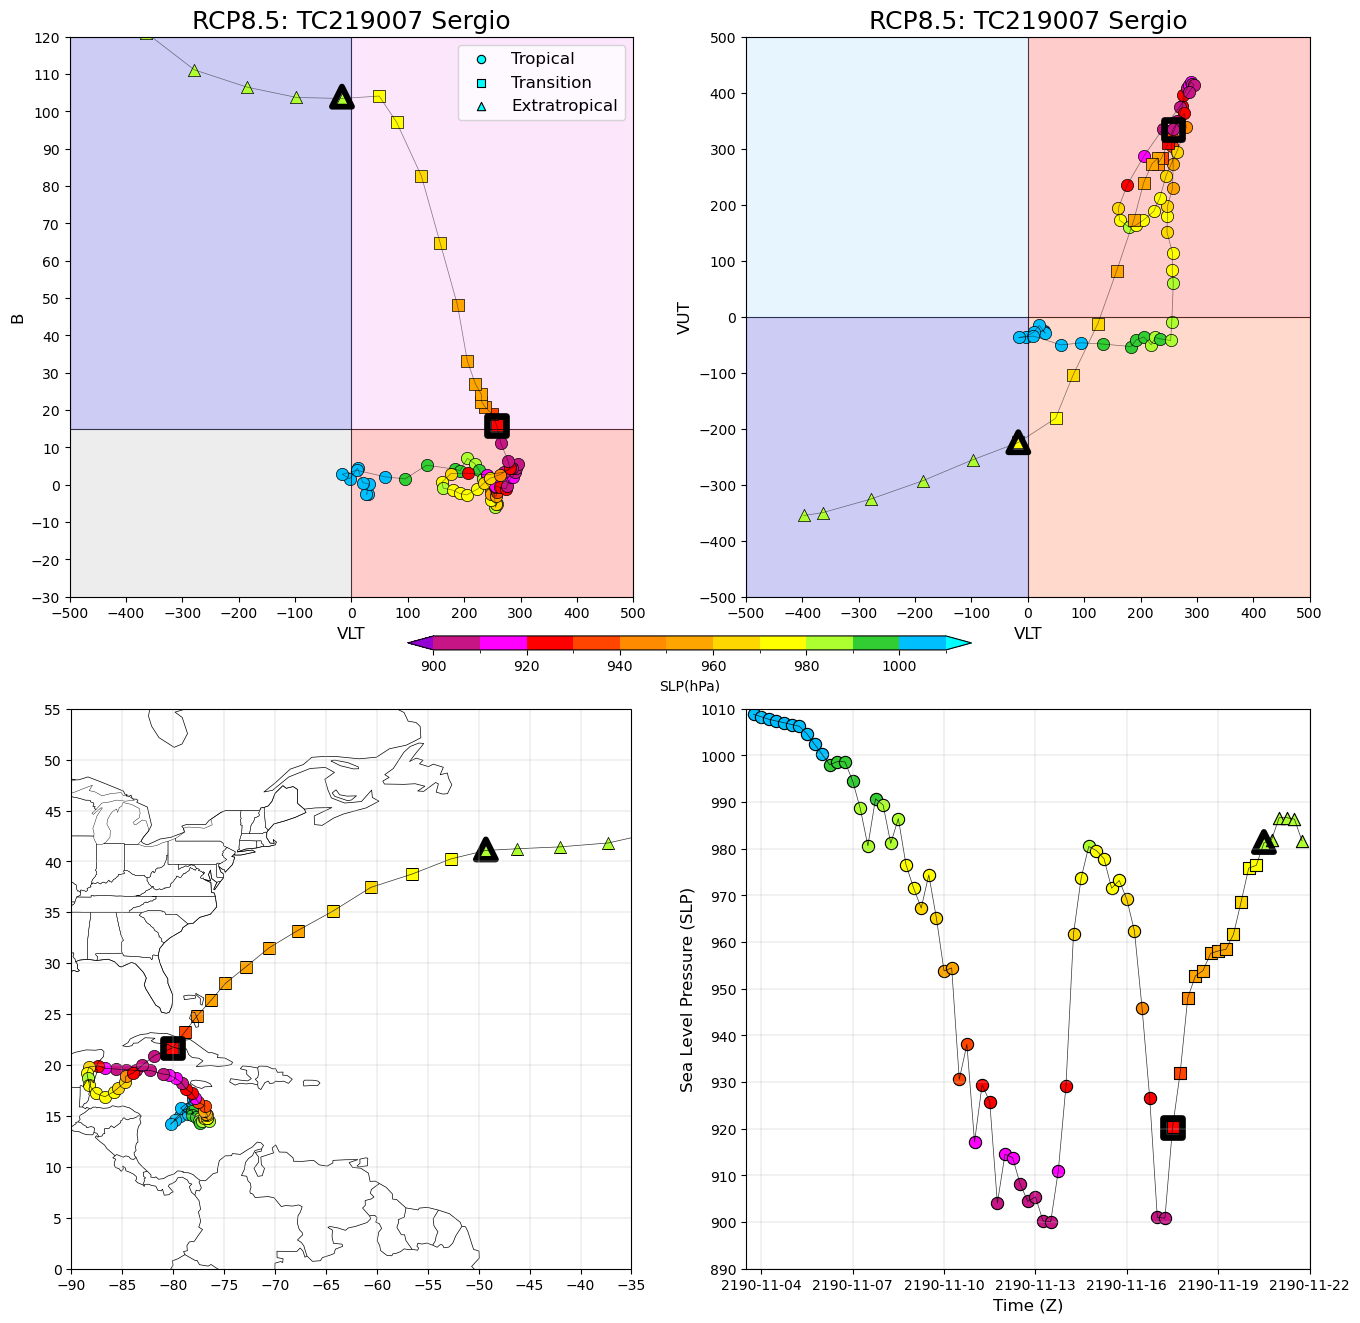

In [37]:
# Input Code
Plot_Cyclone_Info("Sergio", DF_Sergio, ET_Sergio, SLP_Bounds, SLP_Colours, 1, True, "RCP8.5", False, True)

In [38]:
DF_Rachel = Find_Storm(RCP85_Data, "TC216105")

In [39]:
ET_Rachel = Find_Storm(RCP85_ET, "TC216105")

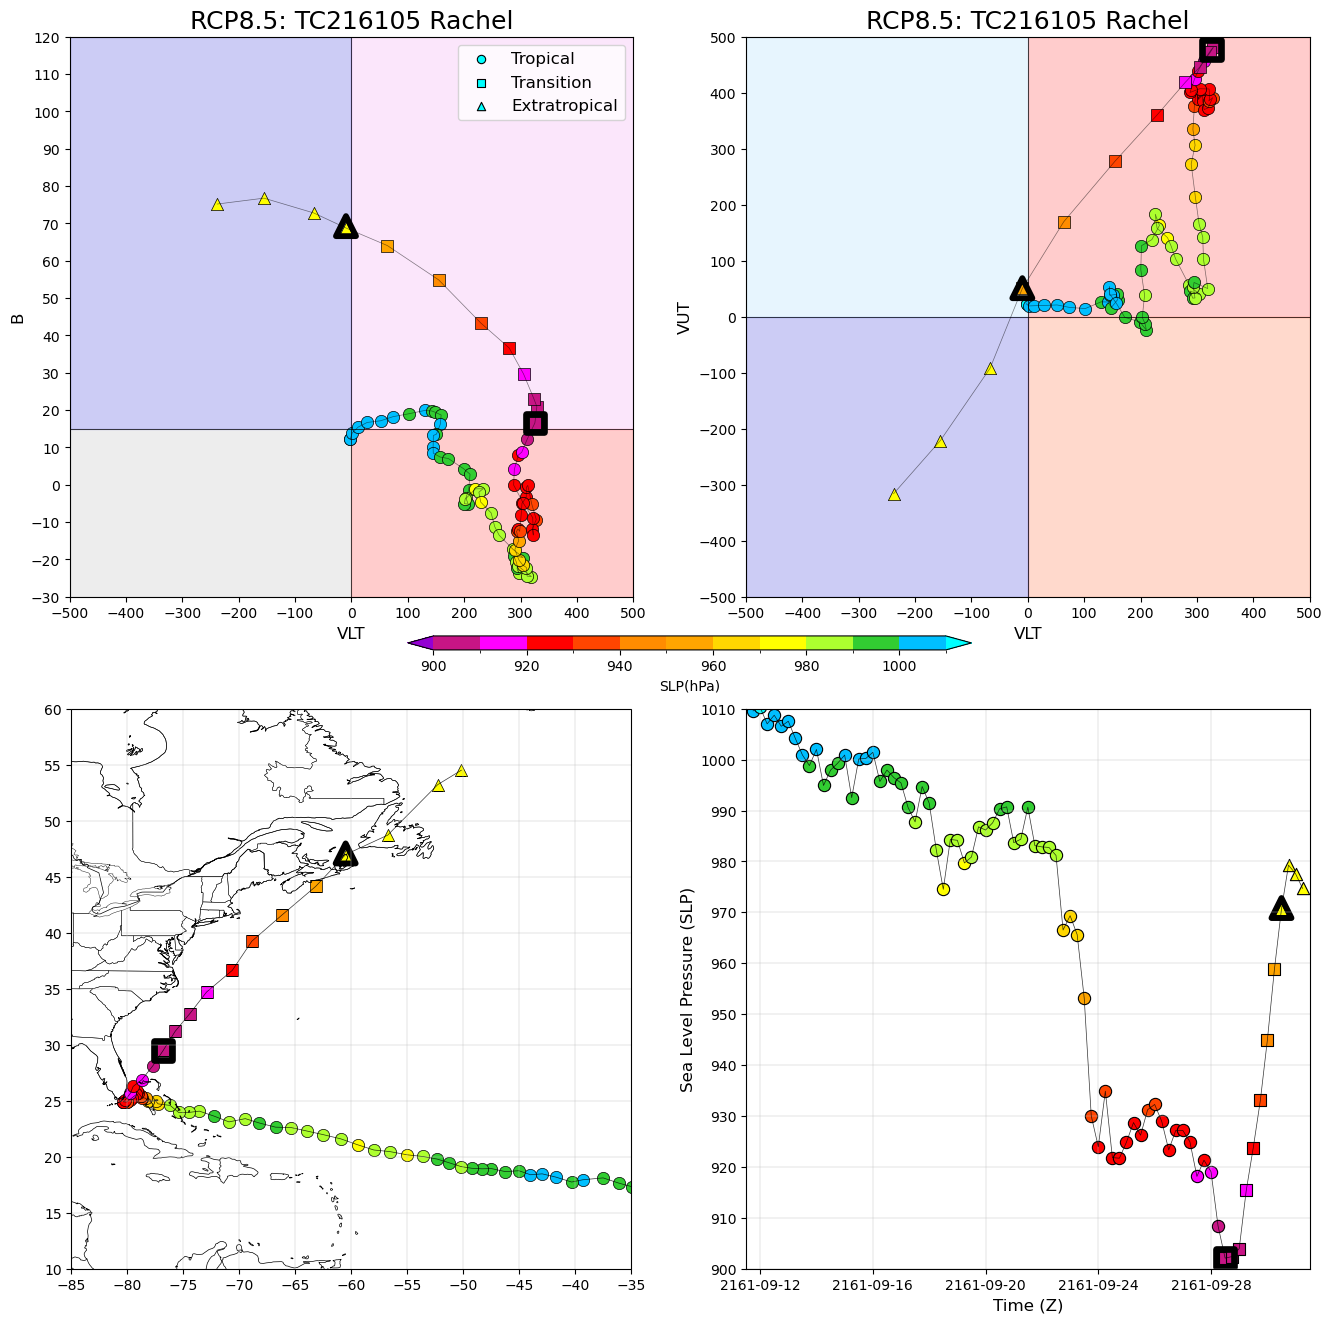

In [40]:
# Input Code
Plot_Cyclone_Info("Rachel", DF_Rachel, ET_Rachel, SLP_Bounds, SLP_Colours, 1, True, "RCP8.5", False, True)